In [1]:
from dotenv import load_dotenv
from langchain_cohere import ChatCohere

load_dotenv()

llm = ChatCohere(model="command-r-plus")


In [2]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [3]:
from typing import Annotated, List
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

In [4]:
from typing import Literal
from pydantic import BaseModel
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    print(result)
    return {
        "messages": [HumanMessage(content=result.content, name=name)]
    }


system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)           


def create_team_supervisor(llm, system_prompt, members) -> str:
    options = ["FINISH"] + members
    class routeResponse(BaseModel):
        next: Literal[*options]
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "user",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), members=", ".join(members))
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    print('prompt: ', prompt)
    return supervisor_chain


def create_agent(llm, user_message: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "user",
                user_message
            )
        ]
    )
    return prompt | llm


In [5]:
import operator
import functools
from typing import Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.prebuilt import create_react_agent


class AffirmativeTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

affirmative_antithesis_agent = create_agent(
    llm, 
    user_message="Given the previous response provided by the opponent team, "
    "provide valid and meaningful counter arguments,"
    " if your team is first, then create arguments for your teams' side."
)
affirmative_antithesis_node = functools.partial(agent_node, agent=affirmative_antithesis_agent, name="Affirmative Antithesis Producer")

affirmative_research_agent = create_react_agent(llm, tools=[tavily_tool])
affirmative_research_node = functools.partial(agent_node, agent=affirmative_research_agent, name="Affirmative Researcher")

affirmative_supervisor_agent = create_team_supervisor(
    llm,
    "You are a supervisor of a opponent debate team tasked with generating a text for the debate with the information gathered from the"
    " following members: Affirmative Antithesis Producer, Affirmative Researcher. Given the following debate topic, or the arguments that are presented by the other "
    " respond with the worker to act next. The chosen member will perform a"
    " task and respond with their results and status. When they finish their task,"
    " generate a beautiful debate text discussing the content you got from the member.",
    ["Affirmative Antithesis Producer", "Affirmative Researcher"],
)

prompt:  input_variables=['messages'] input_types={'messages': typing.List[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_core.message

In [6]:
from langgraph.graph import END, StateGraph, START


affirmative_team_graph = StateGraph(AffirmativeTeamState)
affirmative_team_graph.add_node("Affirmative Antithesis Producer", affirmative_antithesis_node)
affirmative_team_graph.add_node("Affirmative Researcher", affirmative_research_node)
affirmative_team_graph.add_node("Affirmative Supervisor", affirmative_supervisor_agent)

# Define the control flow
affirmative_team_graph.add_edge("Affirmative Antithesis Producer", "Affirmative Supervisor")
affirmative_team_graph.add_edge("Affirmative Researcher", "Affirmative Supervisor")
affirmative_team_graph.add_conditional_edges(
    "Affirmative Supervisor",
    lambda x: x["next"] if "next" in x else "FINISH",
    {"Affirmative Antithesis Producer": "Affirmative Antithesis Producer", "Affirmative Researcher": "Affirmative Researcher", "FINISH": END},
)

affirmative_team_graph.add_edge(START, "Affirmative Supervisor")
affirmative_chain = affirmative_team_graph.compile()



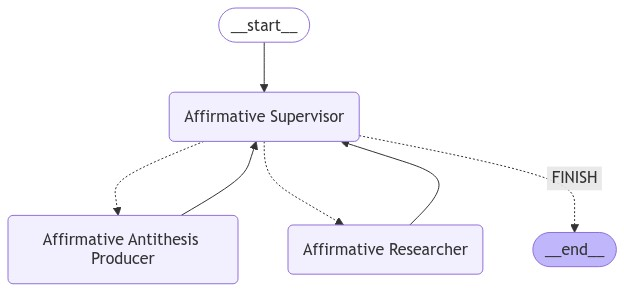

In [7]:
from IPython.display import Image, display

display(Image(affirmative_chain.get_graph().draw_mermaid_png()))


In [8]:
config = {"configurable": {"thread_id": "1"}}

while True:
    user_input = input("USER: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    events = affirmative_chain.stream(
        {"messages": [("user", user_input)]}, config
    )
    print("\n")
    for event in events:
        print(event)
        if 'Affirmative Supervisor' in event and event['Affirmative Supervisor']:
            if event['Affirmative Supervisor']['next'] == "FINISH":
                print('-'*100)
            else:
                print(f"{event['Affirmative Supervisor']['next'].upper()}: ", end="")
        else:
            for agent_name, agent_data in event.items():
                if not agent_data:
                    print("Something went wrong.")
                    break
                for message in agent_data["messages"]:
                    print(f"{message.content}\n")

USER:  euthanasia should be legal




{'Affirmative Supervisor': None}
Something went wrong.


USER:  euthanasia should be legal




{'Affirmative Supervisor': {'next': 'Affirmative Antithesis Producer'}}
AFFIRMATIVE ANTITHESIS PRODUCER: content="I would be happy to help with counter-arguments and arguments for your team's side. In order to do so, please provide me with the response from the opponent team that you would like me to create counter-arguments for, as well as details on the side your team is taking." additional_kwargs={'documents': None, 'citations': None, 'search_results': None, 'search_queries': None, 'is_search_required': None, 'generation_id': 'd4236074-dc8d-491e-a304-e894f9cefdb3', 'token_count': {'input_tokens': 230.0, 'output_tokens': 58.0}} response_metadata={'documents': None, 'citations': None, 'search_results': None, 'search_queries': None, 'is_search_required': None, 'generation_id': 'd4236074-dc8d-491e-a304-e894f9cefdb3', 'token_count': {'input_tokens': 230.0, 'output_tokens': 58.0}} id='run-e433b0ef-7626-44c8-b33e-daeda39fb496-0' usage_metadata={'input_tokens': 230, 'output_tokens': 58, '

KeyboardInterrupt: 